To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=00:60:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=10 srun  --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing
import os
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D          # registers “3d”

In [2]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

Generated random seed 916806139


In [3]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs: {multiprocessing.cpu_count()}")

Node: d-5-1-1
GPUs: 0
CPUs: 96


#### Parameters

In [4]:
circuit_name = "0x17"

#File with designs 
file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks"

Path(output_dir).mkdir(parents=True, exist_ok=True)

In [5]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 7


In [6]:
type(reduced_graphs)

list

In [7]:
#Plot biological circuit designs
for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

Circuit design 0


Circuit design 1


Circuit design 2


Circuit design 3


Circuit design 4


Circuit design 5


Circuit design 6


In [8]:
#Select graph in graphs
selected_graph = 2  

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

# Total valid permutations to process for trainning data
percentage = 0.05    

batch_size = 1000              # Size of each processing batch
solutions_per_file = 250000    # Number of solutions to save per file

In [9]:
num_epochs_toxicity_score_model = 10
num_epochs_circuit_score_model = 10

In [10]:
topology_networkx = reduced_graphs[selected_graph] 

In [11]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (0, 1, 2)
Permuted graphs 1: (0, 2, 1)
Permuted graphs 2: (1, 0, 2)
Permuted graphs 3: (1, 2, 0)
Permuted graphs 4: (2, 0, 1)
Permuted graphs 5: (2, 1, 0)


Base circuit design


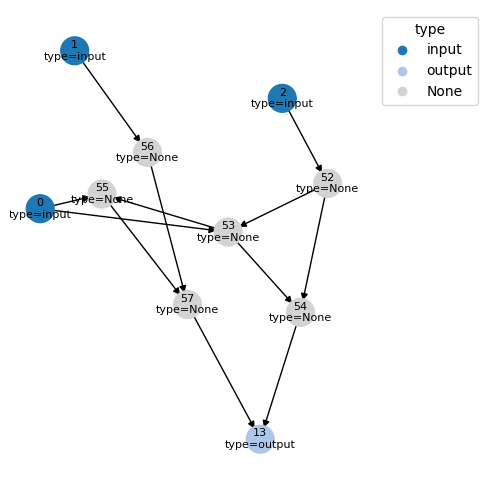

Permutation 0


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 1


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 2


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 3


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 4


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 5


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}


In [12]:
print(f"Base circuit design")
topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)
    

In [13]:
permutation_index = 2

In [14]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

(0, {'type': 'input'})
(1, {'type': 'input'})
(2, {'type': 'input'})
(13, {'type': 'output'})
(52, {})
(53, {})
(54, {})
(55, {})
(56, {})
(57, {})


## Import experimental data

In [15]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

{0: 0.0278, 1: 0.0022, 2: 0.0042}
{0: 0.0278, 1: 0.0022, 2: 2.0082}
{0: 0.0278, 1: 5.0543, 2: 0.0042}
{0: 0.0278, 1: 5.0543, 2: 2.0082}
{0: 3.9239, 1: 0.0022, 2: 0.0042}
{0: 3.9239, 1: 0.0022, 2: 2.0082}
{0: 3.9239, 1: 5.0543, 2: 0.0042}
{0: 3.9239, 1: 5.0543, 2: 2.0082}


In [16]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 1}
{0: 0, 1: 1, 2: 0}
{0: 0, 1: 1, 2: 1}
{0: 1, 1: 0, 2: 0}
{0: 1, 1: 0, 2: 1}
{0: 1, 1: 1, 2: 0}
{0: 1, 1: 1, 2: 1}


In [17]:
'''
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    

input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   
'''

# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


,Repressor,RBS,ymaxa,ymina,Ka,n,Toxicity (RPU)
0,AmeR,F1,3.8350000000,1.0600000000,0.1220000000,1.3060000000,-
1,AmtR,A1,5.0360000000,0.0910000000,0.0220000000,1.3080000000,-
2,BetI,E1,3.0650000000,0.0000000000,0.3630000000,1.8330000000,-
3,BM3R1,B1,0.5430000000,0.0020000000,0.0510000000,2.0420000000,-
4,BM3R1,B2,0.8220000000,0.0000000000,0.2850000000,1.6850000000,-
5,BM3R1,B3,0.7040000000,0.0000000000,0.2610000000,1.7680000000,-
6,HlyIIR,H1,2.4620000000,0.0570000000,0.0000000000,2.5960000000,4.0652500000
7,IcaRA,I1,3.5580000000,0.0000000000,0.1860000000,1.0850000000,0.4709400000
8,LitR,L1,4.2960000000,0.0740000000,0.0000000000,1.6960000000,-
9,LmrA,N1,2.1520000000,0.1830000000,0.0000000000,2.0950000000,-


In [18]:
gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [19]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 6
Info: {'num_nodes': 10, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [20]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_6_gates.h5
Loading valid gate permutations
Total valid permutations: 8739360
Example permutation: (0, 1, 2, 3, 6, 7)


#### Set sample size

In [21]:
num_samples = round(len(valid_permutations)*percentage) 
subsample_size = num_samples

#### Adquire trainning data (multiple cores)

In [22]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

[(1, {'type': 'input'}),
 (0, {'type': 'input'}),
 (2, {'type': 'input'}),
 (13, {'type': 'output'}),
 (52, {}),
 (53, {}),
 (54, {}),
 (55, {}),
 (56, {}),
 (57, {})]

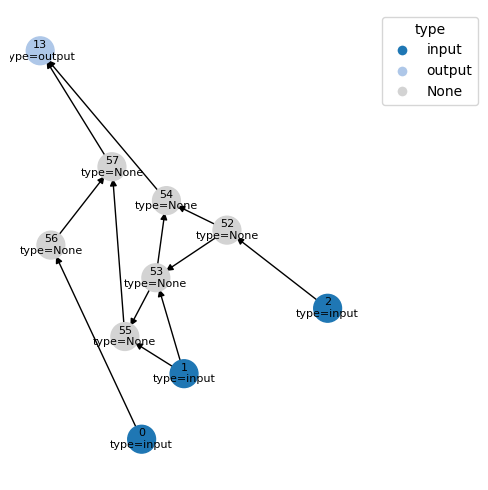

In [23]:
topology_plot_with_attrs(Gi)

In [24]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (13, {'type': 'output'}),
 (52, {}),
 (53, {}),
 (54, {}),
 (55, {}),
 (56, {}),
 (57, {})]

In [25]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

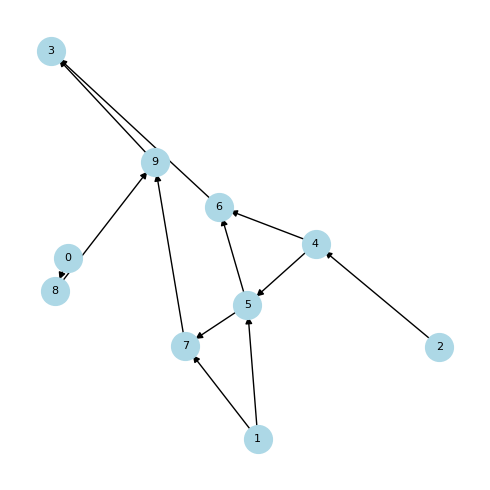

In [26]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)
topology_plot_with_attrs(G)


In [27]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7, 8, 9]

In [28]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [29]:
# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    num_samples=num_samples,           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file     # Save every solutions_per_file solutions
    )

Utilizing all 96 cores for parallel processing
Solutions per file: 250,000
Expected number of files: 2
Selecting 436,968 random solutions from 8,739,360 valid permutations
Processing 437 batches using 96 cores


Processing batches:  57%|██████████████████████████████████████████████████████████████▋                                               | 249/437 [09:26<03:29,  1.11s/batch, Solutions=249,000/436,968, Elapsed=9.5min, Remaining=7.2min, Solutions/sec=436.4]


Saving file 0 with 250,000 solutions...
Successfully saved 250,000 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/training_data_0x17_design_2_permutation_2/results_large_batch_0.pkl


Processing batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [13:36<00:00,  1.87s/batch, Solutions=436,968/436,968, Elapsed=13.7min, Remaining=0.0min, Solutions/sec=533.0]



Saving final file with 186,968 solutions...
Successfully saved 186,968 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/training_data_0x17_design_2_permutation_2/results_large_batch_1.pkl

Processing completed!
Total solutions processed: 436,968
Total time: 13.7 minutes
Average processing speed: 530.7 solutions/second
Total files created: 2


### Load training data

In [30]:
# Load all results
(permutations, toxicity_scores, circuit_scores, roadblocking_flags) = load_circuit_results(Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

Found 2 batch files to load


Loading results: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]



Loading completed:
Total results loaded: 436,968
Unique permutations: 436,968
Average circuit score: 0.765
Average toxicity score: 0.552
Roadblocking percentage: 35.0%

Data shape summary:
Permutations shape: (436968, 6)
Toxicity scores shape: (436968,)
Circuit scores shape: (436968,)
Roadblocking flags shape: (436968,)


### List top biological designs in the training data

In [31]:
no_roadblock_mask_training_data = ~roadblocking_flags
permutations_no_roadblocking_training_data = permutations[no_roadblock_mask_training_data]
circuit_scores_no_roadblocking_training_data = circuit_scores[no_roadblock_mask_training_data]
toxicity_scores_no_roadblocking_training_data = toxicity_scores[no_roadblock_mask_training_data]
roadblocking_flags_no_roadblocking_training_data = roadblocking_flags[no_roadblock_mask_training_data]

toxicity_filter_training_data = toxicity_scores_no_roadblocking_training_data >= 0.75
permutations_no_roadblocking_toxicity_filtered_training_data = permutations_no_roadblocking_training_data[toxicity_filter_training_data]
circuit_scores_no_roadblocking_toxicity_filtered_training_data = circuit_scores_no_roadblocking_training_data[toxicity_filter_training_data]
toxicity_scores_no_roadblocking_toxicity_filtered_training_data = toxicity_scores_no_roadblocking_training_data[toxicity_filter_training_data]
roadblocking_flags_no_roadblocking_toxicity_filtered_training_data = roadblocking_flags_no_roadblocking_training_data[toxicity_filter_training_data]

#print(circuit_scores_no_roadblocking_toxicity_filtered_training_data)

In [32]:
print(len(circuit_scores_no_roadblocking_toxicity_filtered_training_data))

1760


In [33]:
# Find top N circuit scores
N_training_data = 10  # Change this number to get more or fewer top scores
top_n_indices_training_data = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered_training_data)[-N_training_data:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N_training_data} Circuit Scores (no roadblocking, toxicity >= 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details_training_data = {}

for rank, idx in enumerate(top_n_indices_training_data, 1):
    
    corresponding_index_training_data = idx

    best_permutation_training_data = permutations_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    roadblock_flag_training_data = roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx]:13.4f} | "
          f"{str(roadblock_flag_training_data):11} | {best_permutation_training_data}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details_training_data = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'roadblocking': roadblock_flag_training_data,
            'permutation': best_permutation_training_data
        }

# Print detailed information for highest scoring design after the table
print("\n" + "-"*100)
print("Detailed information for highest scoring design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details_training_data['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details_training_data['toxicity_score']}")
print(f"Roadblocking: {highest_score_details_training_data['roadblocking']}")
print(f"Permutation: {highest_score_details_training_data['permutation']}")


Top 10 Circuit Scores (no roadblocking, toxicity >= 0.75):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |      41.1169 |        0.7799 | False       | [ 1 15 11  2 19  5]
   2 |      25.8309 |        0.7733 | False       | [ 1 15  4  2 17 11]
   3 |      19.7239 |        0.7632 | False       | [ 1 11  2 17 13 15]
   4 |      18.1922 |        0.7611 | False       | [15  2 11 19  1  5]
   5 |      16.0887 |        0.7674 | False       | [ 1  2  4 13 15 19]
   6 |      15.4327 |        0.7895 | False       | [ 1 19  4 15  2 11]
   7 |      13.3662 |        0.7662 | False       | [13 15  5 19  2 11]
   8 |      12.3070 |        0.7510 | False       | [12  2 19  1 15  5]
   9 |      12.0140 |        0.7649 | False       | [ 1 17 11 15  2  5]
  10 |      11.8759 |        0.7547 | False       | [17  2 15  1  5 11]

---------------------------------------------------

In [34]:
rows = []
for rank, idx in enumerate(top_n_indices_training_data, 1):
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Toxicity Score"  : toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Roadblocking"    : roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[idx],
        "Permutation"     : permutations_no_roadblocking_toxicity_filtered_training_data[idx],
    })


csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_in_trainning_data_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 10 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/scores_top_designs_in_trainning_data_0x17_2_2.csv


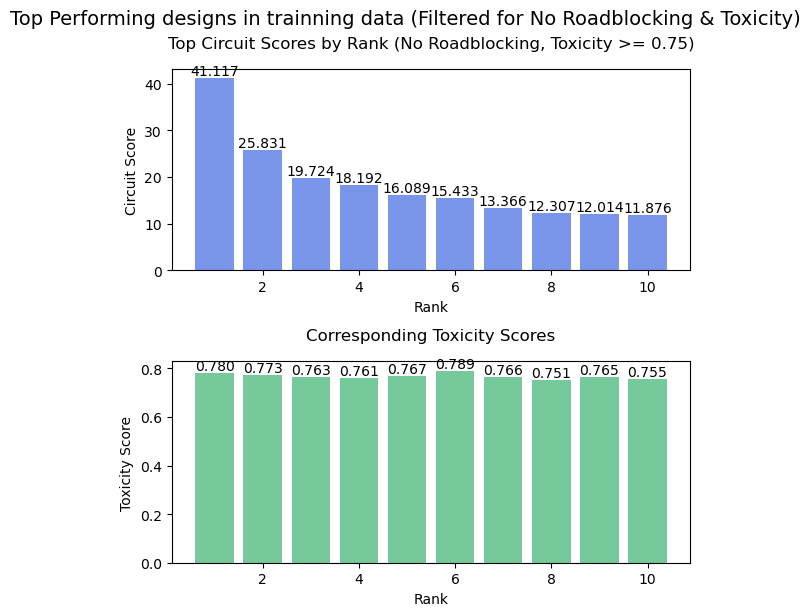


Statistics Summary:
--------------------------------------------------
Circuit Scores - Mean: 18.595, Std: 8.559
Toxicity Scores - Mean: 0.767, Std: 0.011


In [35]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N_training_data + 1))
circuit_scores_training_data_top = circuit_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]
toxicity_scores_training_data_top = toxicity_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores_training_data_top, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank (No Roadblocking, Toxicity >= 0.75)', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
#ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores_training_data_top, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
#ax2.grid(False, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Top Performing designs in trainning data (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores_training_data_top):.3f}, Std: {np.std(circuit_scores_training_data_top):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores_training_data_top):.3f}, Std: {np.std(toxicity_scores_training_data_top):.3f}")

## Define model

In [36]:
class MultiTaskRegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size=200, depth=8, head_hidden_size=200, dropout=0.0):
        super().__init__()
        self.flatten = nn.Flatten()

        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        for _ in range(depth - 1):
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        self.torso = nn.Sequential(*layers)

        # Small per-task specialization layers
        self.head_circuit = nn.Sequential(
            nn.Linear(hidden_size, head_hidden_size), nn.ReLU(),
            nn.Linear(head_hidden_size, 1)
        )
        self.head_toxicity = nn.Sequential(
            nn.Linear(hidden_size, head_hidden_size), nn.ReLU(),
            nn.Linear(head_hidden_size, 1)
        )

    def forward(self, x):
        x = self.flatten(x)  # handles (N, parts, classes) -> (N, parts*classes)
        z = self.torso(x)
        y_circuit = self.head_circuit(z)
        y_toxicity = self.head_toxicity(z)
        return y_circuit, y_toxicity


### Prepare data for training 

In [37]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

num_classes = len(postech_v1_hill_function_parameters)
num_biological_parts = gate_count

In [38]:
# Data Preparation and Filter by circuit score > 0and roadblocking
#filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)

# Data Preparation and Filter by circuit score > n
filter_mask = y_all[:, 1] >= 0

X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data
train_ratio = 0.8
num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)

train_indices = np.random.choice(num_samples, num_train, replace=False)
train_mask = np.zeros(num_samples, dtype=bool)
train_mask[train_indices] = True

X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_mask]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_mask]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_mask]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[~train_mask]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[~train_mask]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[~train_mask]

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Initialization
input_size = num_biological_parts * num_classes
hidden_size = 200
output_size = 1


model_mtl = MultiTaskRegressionNN(
    input_size=input_size, hidden_size=200, depth=8, head_hidden_size=200, dropout=0.0
).to(device)

criterion = nn.MSELoss()
optimizer_model_mtl = optim.Adam(model_mtl.parameters(), lr=0.001)
#optimizer_circuit_score = optim.Adam(model_circuit_score.parameters(), lr=0.001)
#optimizer_toxicity_score = optim.Adam(model_toxicity_score.parameters(), lr=0.001)

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)

Data  436968
Using device: cpu


### Trainning

In [39]:
history = train_multitask_minibatch(
    model_mtl,
    X_training_set_shuffled, y_circuit_scores_training_set_shuffled, y_toxicity_scores_training_set_shuffled,
    X_test_set,            y_circuit_scores_test_set,              y_toxicity_scores_test_set,
    num_epochs=12, batch_size=4096, lr=1e-3, alpha=None, beta=None,  # alpha/beta auto-balanced by variance
    grad_clip=None, seed=42, device=device
)

Epoch 01 | train: total=4.20093, circuit=1.43847, tox=0.02720  ||  val: total=2.04232, circuit=1.53789, tox=0.00810
Epoch 02 | train: total=1.30008, circuit=1.40414, tox=0.00255  ||  val: total=1.16350, circuit=1.53923, tox=0.00056
Epoch 03 | train: total=1.05489, circuit=1.39971, tox=0.00048  ||  val: total=1.14211, circuit=1.53580, tox=0.00039
Epoch 04 | train: total=1.03650, circuit=1.39825, tox=0.00033  ||  val: total=1.13032, circuit=1.53771, tox=0.00028
Epoch 05 | train: total=0.94156, circuit=1.26765, tox=0.00031  ||  val: total=0.63029, circuit=0.82855, tox=0.00033
Epoch 06 | train: total=0.45053, circuit=0.57170, tox=0.00036  ||  val: total=0.36827, circuit=0.46878, tox=0.00029
Epoch 07 | train: total=0.30125, circuit=0.37671, tox=0.00028  ||  val: total=0.25403, circuit=0.31299, tox=0.00026
Epoch 08 | train: total=0.21342, circuit=0.25824, tox=0.00025  ||  val: total=0.21324, circuit=0.25551, tox=0.00026
Epoch 09 | train: total=0.16046, circuit=0.18734, tox=0.00023  ||  val: 

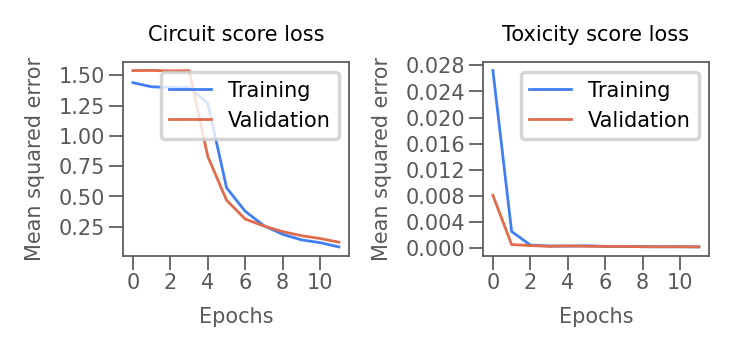

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# history is the dict returned by train_multitask_minibatch(...)
# keys: train_total, val_total, train_circuit, val_circuit, train_toxicity, val_toxicity

# Figure-wide typography and sizing (unchanged)
plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 6,
    "axes.labelsize": 6,
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
})

# Convenience: epoch axis from history length
num_epochs_mtl = len(history["train_circuit"])
epochs = np.arange(num_epochs_mtl)

# Canvas set-up (unchanged)
pt_to_in = lambda pt: pt / 72.0
edge_col, edge_w = "#58595B", 0.5

fig, (ax_circ, ax_tox) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(210), pt_to_in(100)),
    dpi=250,
    sharex=False, sharey=False
)
fig.subplots_adjust(wspace=0.30)

# Loss curves (now read from the multitask history dict)
ax_circ.plot(epochs, history["train_circuit"],
             label="Training",   linewidth=0.8, color="#417FF1")
ax_circ.plot(epochs, history["val_circuit"],
             label="Validation", linewidth=0.8, color="#E06C4B")
ax_circ.set_xlabel("Epochs", labelpad=4)
ax_circ.set_ylabel("Mean squared error", labelpad=4)
ax_circ.set_title("Circuit score loss")
ax_circ.legend(loc="upper right")

ax_tox.plot(epochs, history["train_toxicity"],
            label="Training",   linewidth=0.8, color="#417FF1")
ax_tox.plot(epochs, history["val_toxicity"],
            label="Validation", linewidth=0.8, color="#E06C4B")
ax_tox.set_xlabel("Epochs", labelpad=4)
ax_tox.set_ylabel("Mean squared error", labelpad=4)
ax_tox.set_title("Toxicity score loss")
ax_tox.legend(loc="upper right")

# Shared axis cosmetics
for ax in (ax_circ, ax_tox):
    # frame colour / width
    for spine in ax.spines.values():
        spine.set_color(edge_col)
        spine.set_linewidth(edge_w)

    # tick appearance
    ax.tick_params(direction="out", length=4, width=edge_w, colors=edge_col, pad=1)

    # tidy y-ticks
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

    # label colour
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)

# Adaptive major-tick spacing for x based on epochs
def _nice_step(n, target_ticks=6):
    return max(1, int(np.ceil(n / target_ticks)))

step = _nice_step(num_epochs_mtl)
ax_circ.xaxis.set_major_locator(mticker.MultipleLocator(step))
ax_tox.xaxis.set_major_locator(mticker.MultipleLocator(step))

plt.tight_layout()
plt.show()


In [43]:
fig.savefig(Path(output_dir)  / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/loss_curves_{circuit_name}_{selected_graph}_{permutation_index}.pdf",  # or .png / .svg, etc.
            dpi=250,                         # keep same resolution as on-screen
            bbox_inches="tight")  

### After training, save the models

In [42]:
# Save model
save_model(
    model_mtl,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_mtl_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)



###  Load trained model 

In [44]:
# Initialize the models
input_size = num_biological_parts * num_classes # Must match the input size used during training
hidden_size = 200    # Must match the hidden size used during training
output_size = 1      # Must match the output size used during training

#model_circuit_score = RegressionNN(input_size, hidden_size, output_size)
#model_toxicity_score = RegressionNN(input_size, hidden_size, output_size)
model_mtl = MultiTaskRegressionNN(input_size=input_size, hidden_size=200, depth=8, head_hidden_size=200, dropout=0.0)


# Load model
load_model(
    model_mtl,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_mtl_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)



## Predictions

In [45]:
X_valid_permutations = np.array(valid_permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
# Convert X_filtered to PyTorch tensor and perform one-hot encoding
X_valid_permutations_tensor = th.from_numpy(X_valid_permutations).long()
X_valid_permutations_tensor_one_hot = F.one_hot(X_valid_permutations_tensor, num_classes=20).float()

print("Converted to tensors")

Converted to tensors


In [46]:
len(X_valid_permutations)

8739360

In [47]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model_mtl is your trained MultiTaskRegressionNN
model_mtl = model_mtl.to(device)
model_mtl.eval()

print("Performing predictions")
with th.no_grad():
    start = time.time()

    X = X_valid_permutations_tensor_one_hot.to(device)

    # Forward pass through both heads
    y_predicted_circuit_scores, y_predicted_toxicity_scores = model_mtl(X)

    # Move to CPU + flatten to 1D arrays
    y_predicted_circuit_scores  = y_predicted_circuit_scores.squeeze(-1).cpu().numpy()
    y_predicted_toxicity_scores = y_predicted_toxicity_scores.squeeze(-1).cpu().numpy()

    end = time.time()
    print("\nDone performing predictions. Time to make predictions:", end - start)

Using device: cpu
Performing predictions

Done performing predictions. Time to make predictions: 11.70756483078003


In [54]:
len(X)

8739360

In [51]:
step = 1                  # keep 1 point out of every 10

idx        = np.arange(len(y_predicted_circuit_scores))      # X-axis (sample index)
tox_pred   = np.asarray(y_predicted_toxicity_scores)         # Y-axis (predicted toxicity)
circ_pred  = np.asarray(y_predicted_circuit_scores)          # Z-axis (predicted circuit)

tox_actual  = []       # Y-axis (actual toxicity)
circ_actual = []       # Z-axis (actual circuit)


sel  = slice(None, None, step)          # same as [::step]

# Apply the same selection to all arrays
idx_sub         = idx[sel]
tox_pred_sub    = tox_pred[sel]
circ_pred_sub   = circ_pred[sel]
tox_actual_sub  = tox_actual[sel]
circ_actual_sub = circ_actual[sel]

len(idx)

8739360

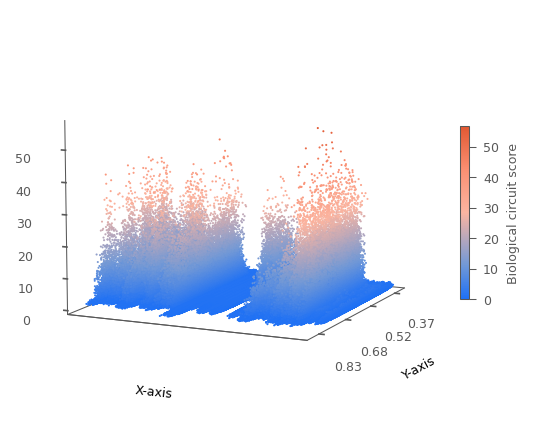

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FixedLocator, FormatStrFormatter  # <-- added
import numpy as np

# === Style params you can tweak ===
AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
LINEWIDTH   = 0.5         # axis, pane edge, and tick width

# Convert once, reuse everywhere
axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

# Set plot parameters
plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

# Create figure and 3D axes
fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
ax = fig.add_subplot(111, projection="3d")

# --- The Definitive Solution using zorder ---
ax.grid(False)

# Draw the floor pane edge on top
ax.zaxis.pane.set_zorder(10)
ax.zaxis.pane.set_alpha(1.0)
ax.zaxis.pane.set_edgecolor(edge_rgba)
ax.zaxis.pane.set_linewidth(LINEWIDTH)

# Make side panes invisible
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')

coldest   = "#1D70F6"   
cold   = "#7399D6"   
middle = "#FBB5A1"   
warm   = "#FA8F72"   
warmest   = "#E15832" 

cw_mid = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_mid",
    [(0.00, coldest),
     (0.20, cold),
     (0.50, middle),
     (0.75, warm),
     (1.00, warmest)],
    N=256)                     

cmap = cw_mid                       
norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

mask = circ_pred_sub >= 0
x_pos   = idx_sub[mask]
y_pos   = tox_pred_sub[mask]
z_pos   = circ_pred_sub[mask]

ax.scatter(
    x_pos, y_pos, z_pos, s=1,
    c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
    alpha=1, edgecolors="none", rasterized=True, label="Predicted"
)

ax.zaxis._axinfo["juggled"] = (1, 2, 0)
ax.view_init(elev=10, azim=115)

#ax.set_zlim(bottom=0.9)
Z_EDGE_PAD_FRAC = 0.0  # no extra space on Z
# If you want the floor at exactly 0 (like your second code):
zlo = 0.0
zhi = float(np.nanmax(z_pos))
ax.set_zlim(zlo, zhi)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# === Shrinkable equal border gaps for Y major ticks ===
# pick how many major ticks to SHOW (inside the limits)
N_YTICKS = 5
BORDER_RATIO = 0.3 # 1.0 = border gap equals interior spacing; 0.5 = half; 0 = ticks on borders

y0, y1 = ax.get_ylim()  # after plotting so autoscale is done
d = (y1 - y0) / (N_YTICKS - 1 + 2*BORDER_RATIO)  # interior spacing
g = BORDER_RATIO * d                               # border gap size
y_ticks = y0 + g + d * np.arange(N_YTICKS)

ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # optional formatting

# Axis line styles (x, y, z)
for a in (ax.xaxis, ax.yaxis, ax.zaxis):
    a.line.set_color(axis_rgba)
    a.line.set_linewidth(LINEWIDTH)

# Tick marks: same color & width on all three axes
for axis in ('x', 'y', 'z'):
    ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

# (Optional) If you also want tick LABELS to match the color:
for axis in ('x', 'y', 'z'):
    ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

# Circuit score
ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

# Permutations
ax.xaxis._axinfo["tick"]["outward_factor"] = -0.5
ax.xaxis.set_tick_params(direction="out")

# Toxicity
ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
ax.yaxis.set_tick_params(direction="out")

# ---- Colorbar (scale bar) styled to match ----
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
cbar = fig.colorbar(
    mappable, ax=ax,
    fraction=0.03, pad=0.06, shrink=0.4, aspect=20
)

# Outline/border
cbar.outline.set_edgecolor(axis_rgba)
cbar.outline.set_linewidth(LINEWIDTH)

# Tick marks & tick labels
cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

# Label (text) color
cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

# === Tighten data-to-edge gaps on all axes ===
EDGE_PAD_FRAC = 0.02  # % of data span on each side; lower => tighter

def limits_with_pad(data, frac=EDGE_PAD_FRAC):
    data = np.asarray(data)
    lo = float(np.nanmin(data))
    hi = float(np.nanmax(data))
    span = hi - lo
    if span <= 0:
        # Constant data: pad relative to magnitude (or small absolute pad)
        base = max(abs(hi), 1.0)
        pad = base * frac
        return lo - pad, hi + pad
    pad = span * frac
    return lo - pad, hi + pad

EDGE_PAD_FRAC_X = 0.005
xlim = limits_with_pad(x_pos, frac=EDGE_PAD_FRAC_X)
ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC)
zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC)

zlim = (0.0, zlim[1]) 
ax.set_xlim(*xlim); 
ax.set_ylim(*ylim); 
ax.set_zlim(*zlim)


#to delete the permutation tick marks and text
ax.set_xticks([])

# === Even edge gaps for Y ticks (inside limits) ===
N_YTICKS = 6
Y_BORDER_RATIO = 0.35  # 1.0: border gap == interior spacing; 0.0: ticks on border
y0, y1 = ax.get_ylim()
d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)
g_y = Y_BORDER_RATIO * d_y
y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)
ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# to delete the permutation tick marks and text
#ax.set_xticks([])


# === Exactly 4 Y major ticks with balanced edge gaps ===
N_YTICKS = 4
Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

y0, y1 = ax.get_ylim()  # after autoscale
d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
g_y = Y_BORDER_RATIO * d_y                            # border gap size
y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.rcParams['svg.fonttype'] = 'none'   # for SVG
plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)



#plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
#fig.savefig(plot_path, dpi=300, bbox_inches="tight", pad_inches=0.02)


In [55]:
plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
fig.savefig("plot_path", dpi=300, bbox_inches="tight", pad_inches=0.02)

In [ ]:
plot_path

In [ ]:
#stop

In [ ]:
#fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
#stop

### Characterize performance on the test set

In [56]:
# Shared-torso model: predictions on test set ---
model_mtl.eval()
model_mtl = model_mtl.to(device)

# Ensure test tensors are on the same device
X_test_set = X_test_set.to(device)

with th.no_grad():
    pred_circuit, pred_toxicity = model_mtl(X_test_set)

# Convert to NumPy for plotting
test_pred_circuit   = pred_circuit.squeeze(-1).detach().cpu().numpy()
test_pred_toxicity  = pred_toxicity.squeeze(-1).detach().cpu().numpy()
test_actual_circuit = y_circuit_scores_test_set.detach().cpu().numpy().flatten()
test_actual_toxicity= y_toxicity_scores_test_set.detach().cpu().numpy().flatten()

'''
# Get model predictions on test set
model_circuit_score.eval()
model_toxicity_score.eval()

# Move test data and models to available device
model_circuit_score = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)
X_test_set = X_test_set.to(device)

# Make predictions
with th.no_grad():
    test_pred_circuit = model_circuit_score(X_test_set)
    test_pred_toxicity = model_toxicity_score(X_test_set)

# Convert everything to numpy arrays for plotting
test_pred_circuit = test_pred_circuit.cpu().numpy().flatten()
test_pred_toxicity = test_pred_toxicity.cpu().numpy().flatten()
test_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()
test_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()
'''

'\n# Get model predictions on test set\nmodel_circuit_score.eval()\nmodel_toxicity_score.eval()\n\n# Move test data and models to available device\nmodel_circuit_score = model_circuit_score.to(device)\nmodel_toxicity_score = model_toxicity_score.to(device)\nX_test_set = X_test_set.to(device)\n\n# Make predictions\nwith th.no_grad():\n    test_pred_circuit = model_circuit_score(X_test_set)\n    test_pred_toxicity = model_toxicity_score(X_test_set)\n\n# Convert everything to numpy arrays for plotting\ntest_pred_circuit = test_pred_circuit.cpu().numpy().flatten()\ntest_pred_toxicity = test_pred_toxicity.cpu().numpy().flatten()\ntest_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()\ntest_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()\n'

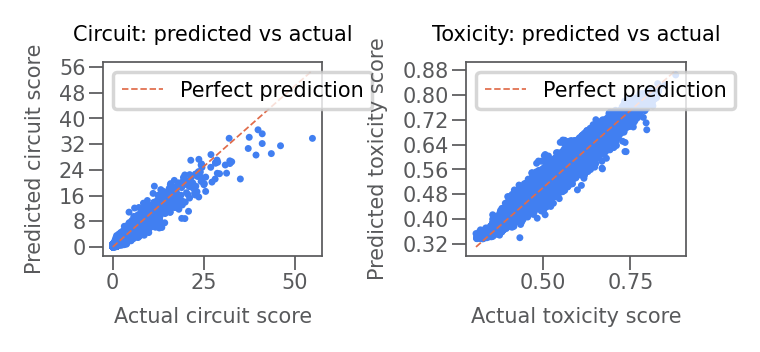


Test-set circuit score:
  MSE  = 0.1227
  RMSE = 0.3503
  R²   = 0.9202
  ρ    = 0.9622

Test-set toxicity score:
  MSE  = 0.0002
  RMSE = 0.0137
  R²   = 0.9780
  ρ    = 0.9892


In [57]:
plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72           

fig, (ax_circ, ax_tox) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(210), pt_to_in(100)),  
    dpi=250,
    sharex=False, sharey=False
)
fig.subplots_adjust(wspace=0.30)

ax_circ.scatter(test_actual_circuit, test_pred_circuit,
                s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_circ.plot([test_actual_circuit.min(), test_actual_circuit.max()],
             [test_actual_circuit.min(), test_actual_circuit.max()],
             linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_circ.set_xlabel("Actual circuit score",  labelpad=4)
ax_circ.set_ylabel("Predicted circuit score", labelpad=4)
ax_circ.set_title("Circuit: predicted vs actual")
ax_circ.legend(loc="upper left", markerscale=5)

ax_tox.scatter(test_actual_toxicity, test_pred_toxicity,
               s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_tox.plot([test_actual_toxicity.min(), test_actual_toxicity.max()],
            [test_actual_toxicity.min(), test_actual_toxicity.max()],
            linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_tox.set_xlabel("Actual toxicity score",   labelpad=4)
ax_tox.set_ylabel("Predicted toxicity score", labelpad=4)
ax_tox.set_title("Toxicity: predicted vs actual")
ax_tox.legend(loc="upper left", markerscale=5)

for ax in (ax_circ, ax_tox):
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

plt.tight_layout()
plt.show()

test_circuit_corr     = np.corrcoef(test_actual_circuit,  test_pred_circuit)[0, 1]
test_toxicity_corr    = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]
test_circuit_mse      = mean_squared_error(test_actual_circuit,  test_pred_circuit)
test_toxicity_mse     = mean_squared_error(test_actual_toxicity, test_pred_toxicity)

print("\nTest-set circuit score:")
print(f"  MSE  = {test_circuit_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_circuit_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_circuit,  test_pred_circuit):.4f}")
print(f"  ρ    = {test_circuit_corr:.4f}")

print("\nTest-set toxicity score:")
print(f"  MSE  = {test_toxicity_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_toxicity_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_toxicity, test_pred_toxicity):.4f}")
print(f"  ρ    = {test_toxicity_corr:.4f}")


In [58]:
metrics_csv = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_performance_on_testing_set.csv"

df = pd.DataFrame([
    ["circuit",  len(test_actual_circuit),  test_circuit_mse,  np.sqrt(test_circuit_mse),
     r2_score(test_actual_circuit,  test_pred_circuit),  test_circuit_corr],
    ["toxicity", len(test_actual_toxicity), test_toxicity_mse, np.sqrt(test_toxicity_mse),
     r2_score(test_actual_toxicity, test_pred_toxicity), test_toxicity_corr],
], columns=["task", "n", "MSE", "RMSE", "R2", "PearsonR"])

df.to_csv(metrics_csv, index=False, mode="a", header=not os.path.exists(metrics_csv))
print(f"Saved metrics to {metrics_csv}")

Saved metrics to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/model_performance_on_testing_set.csv


In [59]:
fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/predictions_on_test_set_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")


In [60]:
np.arange(X_all.shape[0]) 

array([     0,      1,      2, ..., 436965, 436966, 436967])

## Find top designs

#### Filter condition is where predicted circuit score is above a threshold

In [61]:
circuit_score_threshold = 2
filter_condition_for_circuit_score = y_predicted_circuit_scores >= circuit_score_threshold
(y_predicted_circuit_scores >= circuit_score_threshold).sum()

245858

In [62]:
len(filter_condition_for_circuit_score)

8739360

#### Filter condition is where predicted toxicity score is above a threshold

In [63]:
toxicity_score_threshold = 0.5
filter_condition_for_toxicty_score = y_predicted_toxicity_scores >= toxicity_score_threshold
(y_predicted_toxicity_scores >= toxicity_score_threshold).sum()

5893027

In [64]:
len(filter_condition_for_toxicty_score)

8739360

#### Select and save permutations predicted to be high-performing

In [65]:
mask_both_circuit_and_tox_score = filter_condition_for_circuit_score & filter_condition_for_toxicty_score
idx_predicted_to_have_high_scores = np.flatnonzero(mask_both_circuit_and_tox_score)

In [66]:
len(idx_predicted_to_have_high_scores)

173836

In [67]:
gate_assignments_predicted_to_have_high_scores = X_valid_permutations[idx_predicted_to_have_high_scores]

print(len(gate_assignments_predicted_to_have_high_scores))
# Save the array

#np.save(Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy", gate_assignments_predicted_to_have_high_scores)

np.save(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/" \
       f"gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy",
       gate_assignments_predicted_to_have_high_scores)

173836


#### Load permutations predicted to be high-performing

In [68]:
gate_assignments_predicted_to_have_high_scores = np.load(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy")

# Convert to list of tuples
gate_assignments_predicted_to_have_high_scores_list_of_tuples = [
    tuple(np.int64(x) for x in tup) 
    for tup in gate_assignments_predicted_to_have_high_scores
]


In [69]:
len(gate_assignments_predicted_to_have_high_scores)

173836

#### Calculate actual scores and save

In [70]:
# Initialize your graph and get adjacency matrix
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=gate_assignments_predicted_to_have_high_scores_list_of_tuples,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}",
    num_samples=len(gate_assignments_predicted_to_have_high_scores_list_of_tuples),           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file     # Save every 500,000 solutions
    )

Utilizing all 96 cores for parallel processing
Solutions per file: 173,836
Expected number of files: 1
Selecting 173,836 random solutions from 173,836 valid permutations
Processing 174 batches using 96 cores


Processing batches:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 173/174 [05:21<00:00,  2.73batch/s, Solutions=172,836/173,836, Elapsed=5.4min, Remaining=0.1min, Solutions/sec=533.4]


Saving file 0 with 173,836 solutions...


Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [05:24<00:00,  1.87s/batch, Solutions=173,836/173,836, Elapsed=5.5min, Remaining=0.0min, Solutions/sec=531.1]

Successfully saved 173,836 solutions to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/scores_of_designs_predicted_to_have_high_scores_0x17_2_2/results_large_batch_0.pkl



Processing completed!
Total solutions processed: 173,836
Total time: 5.5 minutes
Average processing speed: 530.6 solutions/second
Total files created: 1


#### Load actual scores if saved

In [71]:
# Load all results
(permutations_high_performing, toxicity_scores_high_performing, 
 circuit_scores_high_performing, roadblocking_flags_high_performing) = load_circuit_results( Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations_high_performing.shape}")
    print(f"Toxicity scores shape: {toxicity_scores_high_performing.shape}")
    print(f"Circuit scores shape: {circuit_scores_high_performing.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags_high_performing.shape}")

Found 1 batch files to load


Loading results: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]



Loading completed:
Total results loaded: 173,836
Unique permutations: 173,836
Average circuit score: 5.435
Average toxicity score: 0.605
Roadblocking percentage: 49.8%

Data shape summary:
Permutations shape: (173836, 6)
Toxicity scores shape: (173836,)
Circuit scores shape: (173836,)
Roadblocking flags shape: (173836,)


### List top biological designs 

In [72]:
no_roadblock_mask = ~roadblocking_flags_high_performing

In [73]:
permutations_high_performing_no_roadblocking = permutations_high_performing[no_roadblock_mask]
circuit_scores_high_performing_no_roadblocking = circuit_scores_high_performing[no_roadblock_mask]
toxicity_scores_high_performing_no_roadblocking = toxicity_scores_high_performing[no_roadblock_mask]
roadblocking_flags_high_performing_no_roadblocking = roadblocking_flags_high_performing[no_roadblock_mask]

In [74]:
toxicity_filter = toxicity_scores_high_performing_no_roadblocking >= 0.75

In [75]:
permutations_high_performing_no_roadblocking_toxicity_filtered = permutations_high_performing_no_roadblocking[toxicity_filter]
circuit_scores_high_performing_no_roadblocking_toxicity_filtered = circuit_scores_high_performing_no_roadblocking[toxicity_filter]
toxicity_scores_high_performing_no_roadblocking_toxicity_filtered = toxicity_scores_high_performing_no_roadblocking[toxicity_filter]
roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered = roadblocking_flags_high_performing_no_roadblocking[toxicity_filter]

In [76]:
print(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)

[ 4.06097803  4.46359428 13.7080352  ... 11.28970227 10.68813302
  1.93503663]


In [77]:
permutations_high_performing_no_roadblocking_toxicity_filtered.shape

(3017, 6)

In [78]:
circuit_scores_high_performing_no_roadblocking_toxicity_filtered.shape

(3017,)

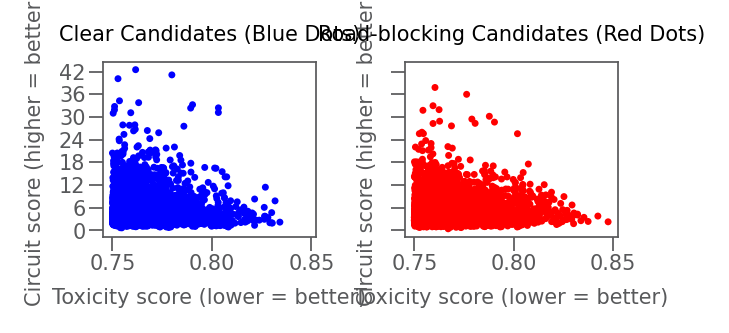

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Added for MaxNLocator

plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72

# toxicity threshold 
tox_thr = 0.75                      

# pick all high-performing samples 
tox_all   = toxicity_scores_high_performing
circ_all  = circuit_scores_high_performing
flags_all = roadblocking_flags_high_performing       # booleans

# build a mask on this full set 
toxicity_filter = tox_all >= tox_thr                 

# apply it once
tox   = tox_all[toxicity_filter]
circ  = circ_all[toxicity_filter]
flags = flags_all[toxicity_filter]       # keeps both True and False

# compute the Pareto front 
order      = np.argsort(tox)           
best_circ  = -np.inf
pareto_idx = []
for i in order:
    if circ[i] > best_circ:
        pareto_idx.append(i)
        best_circ = circ[i]

pareto_mask          = np.zeros_like(circ, dtype=bool)
pareto_mask[pareto_idx] = True          # True → on Pareto front

# color: red = road-blocking, blue = valid 
color_map = np.where(flags, "red", "blue")

# plot 

# Create a figure with 2 subplots (1 row, 2 columns)
# Adjusted figsize and dpi to match the reference code's aesthetic
fig, (ax_left, ax_right) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(270*.7), pt_to_in(135*.7)), # Adjusted for a 2:1 aspect ratio, similar to reference
    dpi=250, # Increased DPI
    sharex=True, sharey=True # Keeping shared axes for better comparison
)
fig.subplots_adjust(wspace=0.30) # Added wspace from reference code

# Plotting for the Left Subplot (Blue Dots - Clear) 
# Filter data for blue dots
blue_mask = (color_map == "blue")
tox_blue = tox[blue_mask]
circ_blue = circ[blue_mask]
pareto_mask_blue = pareto_mask[blue_mask]

# Plot non-Pareto blue dots with styling from reference
ax_left.scatter(tox_blue[~pareto_mask_blue], circ_blue[~pareto_mask_blue],
           s=4, c="blue", alpha=1, edgecolors="none", rasterized=False)

# Plot Pareto blue dots (now styled like non-Pareto points, no highlight)
ax_left.scatter(tox_blue[pareto_mask_blue], circ_blue[pareto_mask_blue],
           s=4, c="blue", alpha=1,
           edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

ax_left.set_xlabel("Toxicity score (lower = better)", labelpad=4) # Added labelpad
ax_left.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
ax_left.set_title("Clear Candidates (Blue Dots)")
# Removed legend as Pareto front is no longer explicitly labeled
# ax_left.legend(frameon=False, loc="upper left", markerscale=5)


# Plotting for the Right Subplot (Red Dots - Road-blocking)
# Filter data for red dots
red_mask = (color_map == "red")
tox_red = tox[red_mask]
circ_red = circ[red_mask]
pareto_mask_red = pareto_mask[red_mask]

# Plot non-Pareto red dots with styling from reference
ax_right.scatter(tox_red[~pareto_mask_red], circ_red[~pareto_mask_red],
           s=4, c="red", alpha=1, edgecolors="none", rasterized=False)

# Plot Pareto red dots 
ax_right.scatter(tox_red[pareto_mask_red], circ_red[pareto_mask_red],
           s=4, c="red", alpha=1,
           edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

ax_right.set_xlabel("Toxicity score (lower = better)", labelpad=4) # Added labelpad
ax_right.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
ax_right.set_title("Road-blocking Candidates (Red Dots)")
# Removed legend as Pareto front is no longer explicitly labeled
# ax_right.legend(frameon=False, loc="upper left", markerscale=5)

# Apply formatting 
for ax in (ax_left, ax_right):
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8)) # Added MaxNLocator

# Adjust layout to prevent overlapping parts
plt.tight_layout()
plt.show()


In [80]:
fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/actual_desings_selected_using_NN_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

### Select how many incoming signals according to repressor

In [81]:

#This excludes NOR BetI
'''
gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}
'''

gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}

# Create DataFrame
gate_max_incoming_signals_df = pd.DataFrame(gate_max_incoming_signals)

In [82]:
valid_NOR_NOT_assignments_flags = []

for perm in (permutations_high_performing_no_roadblocking_toxicity_filtered):
    Gtest = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, perm)
    valid_NOR_NOT_assignments_flags.append(validate_graph_incoming_signals(Gtest, postech_v1_hill_function_parameters, gate_max_incoming_signals_df))

In [83]:
num_true = sum(valid_NOR_NOT_assignments_flags)
num_true

3017

In [84]:
N = 20

In [85]:
# Get indices where validation flags are True
valid_indices = [i for i, flag in enumerate(valid_NOR_NOT_assignments_flags) if flag]

# Filter scores to only include valid circuits
top_n_indices = np.argsort([circuit_scores_high_performing_no_roadblocking_toxicity_filtered[i] for i in valid_indices])[-N:][::-1]
valid_indices_array = np.array(valid_indices)

print(f"\nTop {N} Valid Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

highest_score_details = {}
for rank, idx in enumerate(top_n_indices, 1):
    corresponding_index = valid_indices_array[idx]
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")
    
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'roadblocking': roadblock_flag,
            'permutation': best_permutation
        }

print("\n" + "-"*100)
print("Detailed information for highest scoring valid design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
print(f"Permutation: {highest_score_details['permutation']}")


Top 20 Valid Circuit Scores (no roadblocking, toxicity > 0.75):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |      42.4989 |        0.7617 | False       | [ 1 15 11 19  2  5]
   2 |      41.1169 |        0.7799 | False       | [ 1 15 11  2 19  5]
   3 |      40.1149 |        0.7528 | False       | [15 13 11  2 19  5]
   4 |      34.2730 |        0.7535 | False       | [ 1 15 11  2 19  4]
   5 |      33.7767 |        0.7632 | False       | [ 1 15 11 17  2  5]
   6 |      33.2390 |        0.7903 | False       | [ 1 15  5  2 19 11]
   7 |      32.7719 |        0.7511 | False       | [ 1 17 11  2 13 15]
   8 |      32.4085 |        0.8033 | False       | [ 1 15  4 19  2 11]
   9 |      32.3445 |        0.7893 | False       | [ 1 15  5 19  2 11]
  10 |      31.8813 |        0.7510 | False       | [ 1 19 11  2 13 15]
  11 |      31.1787 |        0.8033 | False    

In [86]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])


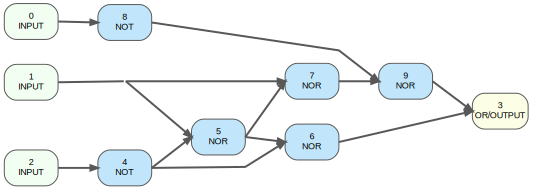

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/optimal_topology_0x17_2_2.svg')

In [87]:
plot_circuit_layered(
    G,
    outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    name=f'optimal_topology_{circuit_name}_{selected_graph}_{permutation_index}',
    fmt="svg",                   
    rankdir="LR",
    show_in_notebook=True,      
    compact=True,
    gv_size="8,4.5!",            
    gv_dpi=None,                 
    gv_margin="0.05",
    gv_pad="0.05"
)

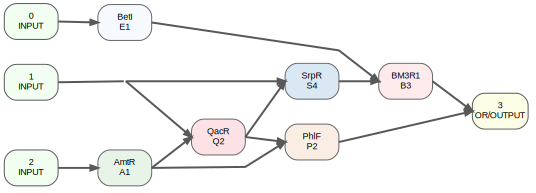

PosixPath('/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/optimal_topology_with_parts_assigned_0x17_2_2.svg')

In [88]:
plot_circuit_with_parts_layered(
    G,
    outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    name=f'optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}',
    fmt="svg",                   
    rankdir="LR",
    show_in_notebook=True,      
    compact=True,
    gv_size="8,4.5!",            
    gv_dpi=None,                 
    gv_margin="0.05",
    gv_pad="0.05"
)

In [89]:
# Calculate toxicity
toxicity_score, _ = calculate_toxicity_score(
    input_signals_list_small_molecules,
    G,
    gate_toxicity_df
)

# Simulate logic
actual_logic = simulate_signal_propagation(
    G,
    input_signals_list_small_molecules
)
expected_logic = simulate_signal_propagation_binary(
    G,
    input_signals_list_binary
)

# Calculate scores
current_score = calculate_circuit_score(expected_logic, actual_logic)
roadblocking_flag = is_roadblocking(G)

print(f'Current score: {current_score}')
print(f'Toxicity score:{toxicity_score}')
print(f'Roadblocking: {roadblocking_flag}')



Current score: 42.49892626547232
Toxicity score:0.7616577178089621
Roadblocking: (False, [])


In [90]:
csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_scores_{circuit_name}_{selected_graph}_{permutation_index}.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Circuit score", "Toxicity score", "Roadblocking"])
    writer.writerow([float(current_score), float(toxicity_score),roadblocking_flag[0]])

In [91]:
list(G.nodes(data = True))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (3, {'type': 'output'}),
 (4,
  {'Repressor': 'AmtR',
   'RBS': 'A1',
   'ymaxa': 5.036,
   'ymina': 0.091,
   'Ka': 0.022,
   'n': 1.308,
   'Toxicity (RPU)': '-'}),
 (5,
  {'Repressor': 'QacR',
   'RBS': 'Q2',
   'ymaxa': 3.778,
   'ymina': 1e-14,
   'Ka': 0.456,
   'n': 1.979,
   'Toxicity (RPU)': '-'}),
 (6,
  {'Repressor': 'PhlF',
   'RBS': 'P2',
   'ymaxa': 6.505,
   'ymina': 1e-14,
   'Ka': 0.16,
   'n': 2.237,
   'Toxicity (RPU)': '-'}),
 (7,
  {'Repressor': 'SrpR',
   'RBS': 'S4',
   'ymaxa': 3.314,
   'ymina': 1e-14,
   'Ka': 0.108,
   'n': 1.344,
   'Toxicity (RPU)': '-'}),
 (8,
  {'Repressor': 'BetI',
   'RBS': 'E1',
   'ymaxa': 3.065,
   'ymina': 1e-14,
   'Ka': 0.363,
   'n': 1.833,
   'Toxicity (RPU)': '-'}),
 (9,
  {'Repressor': 'BM3R1',
   'RBS': 'B3',
   'ymaxa': 0.704,
   'ymina': 1e-14,
   'Ka': 0.261,
   'n': 1.768,
   'Toxicity (RPU)': '-'})]

In [92]:
filename = f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}.pkl"

with open(Path(output_dir)/filename, "wb") as f:
    pickle.dump(G, f)

print(f"Design saved to {filename}")


Design saved to 0x17_design_2_permutation_2/optimal_topology_with_parts_assigned_0x17_2_2.pkl


Export to CSV

In [93]:
rows = []
for rank, idx in enumerate(top_n_indices, 1):
    corr_idx = valid_indices_array[idx]
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Toxicity Score"  : toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Roadblocking"    : roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Permutation"     : permutations_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
    })

csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 20 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks/0x17_design_2_permutation_2/scores_top_designs_0x17_2_2.csv


In [ ]:
stop 

## Previous code

In [ ]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# Optional: Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

#### Draw the top design

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 600, save = False)
plot_circuit_with_parts_layered(G, show_in_notebook=True, notebook_width = 600, save = False)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 500, save = False)

## Simulated annealing

In [ ]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [ ]:
df = postech_v1_hill_function_parameters
initial_solution = random_part_selection(df, length = gate_count)
print(f"Initial solution is {initial_solution}")
Tmax = 100
Tmin = 0.1
iterations_at_Tmin = 10000
iterations_before_Tmin = 1000

simulated_annealing_cello_v3(df, adj_matrix, initial_solution, Tmax, Tmin, iterations_before_Tmin, input_signals_list_small_molecules, input_signals_list_binary, iterations_at_Tmin=iterations_at_Tmin)
